In [ ]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from dataloader import *
# from smol_generator import *
from generator import *
from discriminator import *
from losses import * 
import matplotlib.pyplot as plt
import utilities
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Initial Variables etc..


In [ ]:
# networks 

generator = Generator().to(device)
generator.load_model('/content/drive/MyDrive/trained_models/pretrained_generator.pth')
generator = generator.train()

discriminator = Discriminator().to(device)

VGG = getVGGConv4_4().to(device)


In [ ]:
# losses 

content_loss = ContentLoss(VGG).to(device)
grayscale_loss = GrayscaleStyleLoss(VGG).to(device)
color_recon_loss = ColorReconLoss().to(device)
adversarial_loss = nn.MSELoss().to(device)

In [ ]:
# optimizers

# maybe come back and add weight decay 

pre_train_optim = optim.Adam(generator.parameters(), lr=0.0001)

gen_optim = optim.Adam(generator.parameters(), lr=0.00008)
dis_optim = optim.Adam(discriminator.parameters(), lr=0.00016)

In [ ]:
ANIME_PATH = '/content/drive/MyDrive/dataset/Shinkai/style/'
SMOOTH_PATH = '/content/drive/MyDrive/dataset/Shinkai/smooth/'
PHOTOS_PATH = '/content/drive/MyDrive/dataset/train_photo/'

photo_dataloader = getPhotoDataloader(PHOTOS_PATH)
anime_dataloader = getAnimeDataloader(ANIME_PATH, grayscale=False)
dis_dataloader = getPhotoAndAnimeDataloader(ANIME_PATH, SMOOTH_PATH, PHOTOS_PATH)

## Pretraining on Content Loss Only

before running code, copy and paste the following into `inspect elements -> console`:

```
function ClickConnect(){
  console.log("Connnect Clicked - Start"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End"); 
};
setInterval(ClickConnect, 60000)
```

In [ ]:
# pretraining (only run once)?
PRETRAINING_EPOCHS = 5
BASE_SAVE_PATH = '/content/drive/MyDrive/OverfitGenerator/'

pretrain_loss_list = []

for _ in range(PRETRAINING_EPOCHS):
  for p_batch_idx, photo_batch in enumerate(anime_dataloader):
    pre_train_optim.zero_grad()
    photo_batch = photo_batch.to(device)
    gen_images = generator(photo_batch)
    
    loss = content_loss(gen_images, photo_batch)
    
    loss.backward()
    pre_train_optim.step()
    pretrain_loss_list.append(loss.item())
    
    if p_batch_idx % 100 == 0:
      print("batch:", p_batch_idx, "loss:", loss.item())

  generator.save_model(BASE_SAVE_PATH + 'pretrained_generator' + str(_) + '.pth')

generator.save_model(BASE_SAVE_PATH + 'pretrained_generator.pth')


In [ ]:
# generator.save_model('/content/drive/MyDrive/trained_models/pretrained_smol_generator.pth')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


4

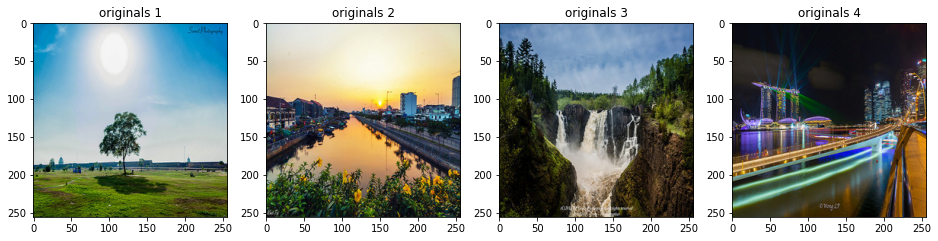

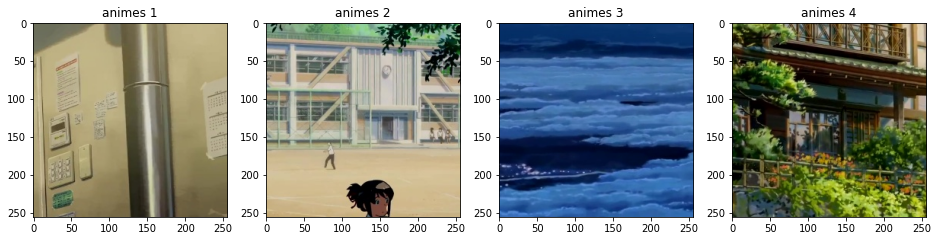

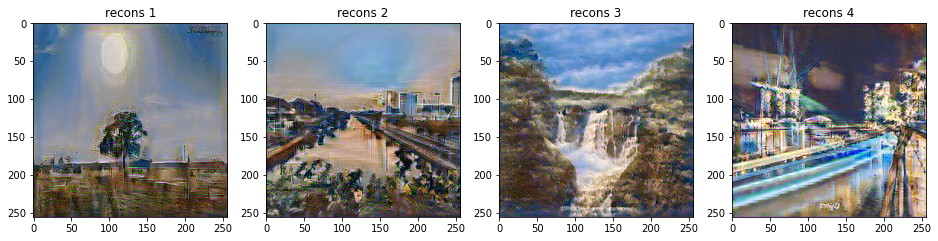

In [ ]:
torch.cuda.empty_cache()
gen_images = generator(photo_batch)
originals = utilities.torch_to_numpy(photo_batch, is_standardized_image=True)
animes = utilities.torch_to_numpy(anime_batch, is_standardized_image=True)
images = utilities.torch_to_numpy(gen_images, is_standardized_image=True)
utilities.plot_images(originals, "originals", 1)
utilities.plot_images(animes, "animes", 2)
utilities.plot_images(images, "recons", 3)
